In [1]:
using Knet
using Images
using Statistics

if Knet.gpu() >= 0
    ATYPE = KnetArray{Float32}
else
    ATYPE = Array{Float32}
end

KnetArray{Float32,N} where N

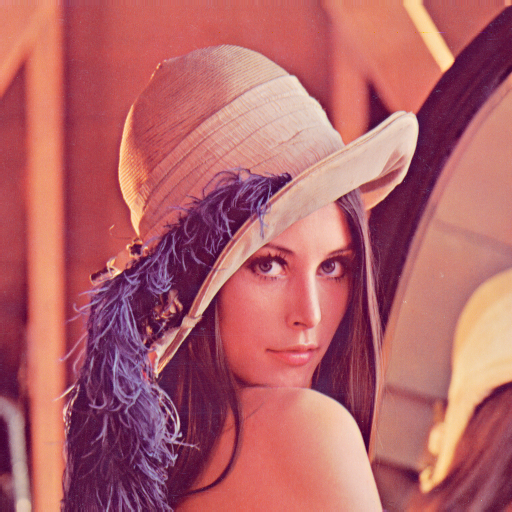

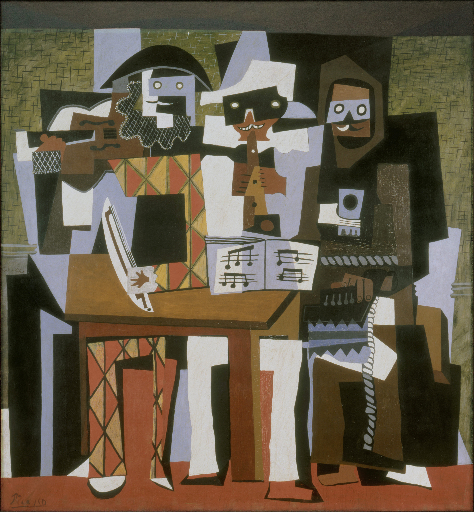

In [2]:
CONTENT_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/Green_Sea_Turtle_grazing_seagrass.jpg"
#CONTENT_URL = "https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png"
#STYLE_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg"
STYLE_URL = "https://upload.wikimedia.org/wikipedia/en/4/4c/Les_Demoiselles_d%27Avignon.jpg"
#STYLE_URL = "https://upload.wikimedia.org/wikipedia/en/6/6a/Pablo_Picasso%2C_1921%2C_Nous_autres_musiciens_%28Three_Musicians%29%2C_oil_on_canvas%2C_204.5_x_188.3_cm%2C_Philadelphia_Museum_of_Art.jpg"

content_img = load(CONTENT_URL)
style_img = load(STYLE_URL)

ratio = 512 / max(size(content_img)...)
content_img = imresize(content_img, ratio=ratio)
ratio = 512 / max(size(style_img)...)
style_img = imresize(style_img, ratio=ratio)

display(content_img)
display(style_img)

content_img = permutedims(channelview(content_img), (2,3,1)) .|> Float32;
style_img = permutedims(channelview(style_img), (2,3,1)) .|> Float32;

In [3]:
using StyleTransfer

STYLE_LAYERS = [:conv1_1, :conv2_1, :conv3_1, :conv4_1, :conv5_1]
CONTENT_LAYER = :conv5_2

extract_features = FeatureExtractor();
MEAN_COLOR = extract_features.mean_color;

In [4]:
function preprocess(x)
    x = x .* 255
    x = reshape(x,size(x)...,1) .- MEAN_COLOR
    convert(ATYPE, x)
end

style_targets = extract_features(style_img |> preprocess, STYLE_LAYERS...) .|> gram_matrix;
content_target = extract_features(content_img |> preprocess, CONTENT_LAYER)[1];

In [5]:
STYLE_LOSS_WEIGHT = 1e10 |> Float32
CONTENT_LOSS_WEIGHT = 1e2 |> Float32

function loss(input)
    outputs = extract_features(preprocess(input), STYLE_LAYERS..., CONTENT_LAYER)
    style_outputs = outputs[1:end-1] .|> gram_matrix
    content_output = outputs[end]
    style_loss = mean(mean((so .- st) .^ 2) for (so, st) in zip(style_outputs, style_targets))
    content_loss = mean((content_output .- content_target) .^ 2)
    style_loss * STYLE_LOSS_WEIGHT + content_loss * CONTENT_LOSS_WEIGHT
end

loss_grad = gradloss(loss);

In [6]:
image = Param(content_img, Adam())
@show loss(image)
@show typeof(loss_grad(image))

loss(image) = 1.3782099f14


┌ Warning: k=(Ptr{Nothing} @0x00007f4966a00000, 524288) v=58 ni=51
└ @ Knet /home/david.lin/.julia/packages/Knet/IIjk8/src/gcnode.jl:114


typeof(loss_grad(image)) = Tuple{Array{Float32,3},Float32}


Tuple{Array{Float32,3},Float32}

In [11]:
for _ in progress(1:5000)
    g, l = loss_grad(image)
    update!(image, g)
end

┣████████████████████┫ [100.00%, 5000/5000, 03:38/03:38, 22.98i/s] 


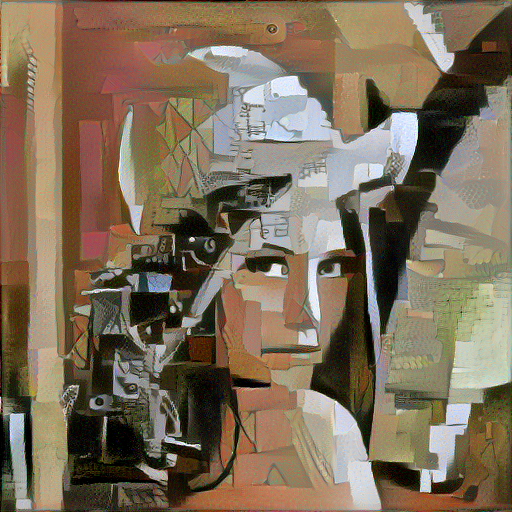

In [12]:
img = permutedims(value(image)[:,:,:,1], (3,1,2))
img = colorview(RGB, img)
display(img)